### WBS Coding School
___
### --PROJECT--
# Unsupervised Machine Learning

In this **Unsupervised Machine Learning** project I analyse a dataset consisting of 5000 songs, create playlists and assign each song to one of them. There is no hard limit for the number of playlists, but I want to keep the size of all the playlists roughly between 50 and 250 songs. Having 5k songs, that means that I will end up with 20 to 100 playlists that each contain between 50 to 250 songs.

My statistical tools are **K-Means Clustering** and **Principal Component Analysis**.

- **Principal component analysis (PCA)** is a powerful technique for analyzing high-dimensional data, such as this dataset of musical features. By reducing the dimensionality of the data, PCA can make it easier to visualize and understand the relationships between the different features. 

- **K-Means clustering** is an unsupervised machine learning algorithm that can be used to group a dataset of musical features into a predefined number of clusters. Each cluster represents a group of songs that share similar musical characteristics. K-Means clustering can be used to identify different genres of music, or to discover new musical genres that may not have been previously identified. It can also be used to group songs together based on their mood or energy level.

The spotify dataset stems from the WBS Coding School website. It includes Spotify's official audio features. You will find details about those features [here](https://developer.spotify.com/documentation/web-api/reference/get-audio-features).

___

## Table of contents:
- [1 Data Preparation](#data_preparation)
- [2 Analysis](#analysis)
    - [2.1 Data Scaling](#scaling)
    - [2.2 K-Means Clustering](#kmeans)
        - [2.2.1 K-Means Number of Clusters](#kmeans_clusters)
        - [2.2.1 K-Means Modelling](#kmeans_modelling)
        - [2.2.2 K-Means Plotting](#kmeans_plotting)
    - [2.3 Principal Component Analysis](#pca)
        - [2.3.1 PCA Modelling](#pca_modelling)
        - [2.3.2 PCA Plotting](#pca_plotting)
- [3 Interpretation](#interpretation)
    - [3.1 Probe playlists](#probing)
    - [3.2 Conclusion](#conclusion)

#### Import Libraries & Dataframes

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(transform_output="pandas")

import seaborn as sns
import plotly.express as px

In [7]:
# Get the data
url = "https://drive.google.com/file/d/1oYQSNxfvw6kFr6-N9rKLRAnLXlp0osEt/view?usp=drive_link"
path = f"https://drive.google.com/uc?export=download&id={url.split('/')[-2]}"

spotify_df = pd.read_csv(path, index_col=[0])

In [8]:
spotify_df.head()

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376,,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039,,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...
3,Mulher Eu Sei ...,Chico César,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802,,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...
4,Rosa Morena ...,Kurt Elling,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.104,0.402,120.941,,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...


___
<a id="data_preparation"></a>
# 1&nbsp; Data Preparation

#### Clean spotify dataframe

In [4]:
# Remove spaces from column names using str.replace()
spotify_clean = spotify_df.copy()
spotify_clean.columns = spotify_clean.columns.str.replace(' ', '')

# Remove duplicate columns
spotify_clean = spotify_clean[-spotify_df.duplicated()]
spotify_clean = spotify_clean.reset_index()

# Remove duplicate songs
spotify_clean = spotify_clean.drop_duplicates(subset=["name", "artist"])

# Remove empty column and old index
spotify_clean = spotify_clean.drop(columns=["type", "index"])

#### Make HTML dataframe

In [5]:
spotify_htmls = spotify_clean.copy()[["name", "artist", "id", "html"]]
spotify_htmls

,name,artist,id,html
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...
1,Saudade De Bahia ...,Antônio Carlos Jobim,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...
3,Mulher Eu Sei ...,Chico César,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...
4,Rosa Morena ...,Kurt Elling,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...
...,...,...,...,...
5166,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,1aEhYlZtypmipA06SDJ4U3,https://open.spotify.com/track/1aEhYlZtypmipA0...
5167,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,1Gfqe7TAKklmuZf6hxsH6h,https://open.spotify.com/track/1Gfqe7TAKklmuZf...
5168,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,2XNwnFrdMDpismp0VUZ7cU,https://open.spotify.com/track/2XNwnFrdMDpismp...
5169,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,7ucDwgMtE3YJtEfTbuRhy0,https://open.spotify.com/track/7ucDwgMtE3YJtEf...


#### Drop unwanted columns

In [6]:
# We do not all the columns for the K-Means Clustering.
# E.g., the length of a song doesn't really matter that much.
# Also the time signature (meter) probably isn't gonna be important for creating playlist.
# Finally, the song IDs and HTMLs aren't needed, given that our name/artist combinations are now unique.

# Remove unwanted features
drop_features = ["duration_ms", "time_signature", "id", "html", "key", "mode"]
spotify_clean = spotify_clean.drop(columns=drop_features)

In [7]:
spotify_clean.info()
spotify_clean.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5114 entries, 0 to 5170
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5114 non-null   object 
 1   artist            5114 non-null   object 
 2   danceability      5114 non-null   float64
 3   energy            5114 non-null   float64
 4   loudness          5114 non-null   float64
 5   speechiness       5114 non-null   float64
 6   acousticness      5114 non-null   float64
 7   instrumentalness  5114 non-null   float64
 8   liveness          5114 non-null   float64
 9   valence           5114 non-null   float64
 10  tempo             5114 non-null   float64
dtypes: float64(9), object(2)
memory usage: 479.4+ KB


,name,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3997,Ritual Acts ...,Necrosanct,0.149,0.955,-6.083,0.0805,0.000251,0.9150,0.1000,0.0377,97.701
1169,Knockin' On Heaven's Door ...,Bob Dylan,0.513,0.396,-13.061,0.0299,0.251000,0.1770,0.1100,0.2290,140.208
299,Thine Eyes ...,Pure Bliss,0.486,0.948,-1.370,0.0339,0.429000,0.7170,0.3360,0.6750,142.325
719,Bailando - English Version ...,Enrique Iglesias,0.723,0.850,-3.508,0.0879,0.084100,0.0000,0.0697,0.9370,90.957
4425,Redeem Deny ...,Abomination,0.412,0.865,-13.070,0.0450,0.012300,0.0321,0.2190,0.6930,117.718


___
<a id="analysis"></a>
# 2&nbsp; Analysis

<a id="scaling"></a>
## 2.1&nbsp; Data Scaling

Which method of scaling will be most adequate for our dataset? Therefore, let's first have a look at the data distribution and basic statistics.

In [8]:
spotify_clean.describe().round(2)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,5114.00,5114.00,5114.00,5114.00,5114.00,5114.00,5114.00,5114.00,5114.00
mean,0.51,0.65,-9.39,0.08,0.29,0.26,0.19,0.44,118.64
std,0.22,0.29,6.32,0.07,0.36,0.37,0.15,0.28,28.63
min,0.00,0.00,-60.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.30,0.48,-11.39,0.04,0.00,0.00,0.09,0.19,96.06
50%,0.53,0.74,-7.37,0.06,0.10,0.00,0.12,0.41,118.99
75%,0.68,0.90,-5.32,0.10,0.57,0.66,0.24,0.67,134.10
max,0.97,1.00,1.34,0.92,1.00,0.98,0.99,0.98,213.99


Our data consists mostly of columns with values ranging between 0-1. Only `loudness` and `tempo` do not fall into this range.

Therefore, I will use minmax scaling on these two columns to get them on the same scale as the others (0-1).

Meanwhile, I'll leave the remaining columns as they are. I want to perform as little data transformation as possible, as you typically lose information during the process.

In [9]:
features_to_minmax_scale = ["loudness", "tempo"]
spotify_features_to_scale = spotify_clean.copy()[features_to_minmax_scale]

In [10]:
# Create a MinMaxScaler object
minmax_scaler = MinMaxScaler().set_output(transform="pandas")

# Scale the two columns `loudness` and `tempo`
minmax_features = minmax_scaler.fit_transform(spotify_features_to_scale)

In [11]:
# Make a new dataframe that includes scaled features
spotify_minmax_scaled = spotify_clean.copy()

# Overwrite unscaled features with scaled ones
spotify_minmax_scaled.drop(labels=features_to_minmax_scale, axis="columns", inplace=True)
spotify_minmax_scaled[features_to_minmax_scale] = minmax_features[features_to_minmax_scale]

The `spotify_minmax_scaled` dataframe now contains all original columns whose values range between 0 and 1, plus the minmax scaled `loudness` and `tempo` columns, now on the same range.

In [12]:
spotify_minmax_scaled.head(5)

,name,artist,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,loudness,tempo
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,0.0705,0.694,0.000059,0.975,0.306,0.763897,0.515800
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,0.0346,0.217,0.000002,0.107,0.693,0.771967,0.584322
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.7300,0.3470,0.453,0.000063,0.124,0.905,0.798018,0.437862
3,Mulher Eu Sei ...,Chico César,0.705,0.0502,0.0471,0.879,0.000041,0.386,0.524,0.682811,0.499098
4,Rosa Morena ...,Kurt Elling,0.651,0.1190,0.0380,0.916,0.000343,0.104,0.402,0.655228,0.565171


<a id="kmeans"></a>
## 2.2&nbsp; K-Means Clustering

<a id="kmeans_clusters"></a>
### 2.2.1&nbsp; K-Means Number of Clusters

Here, I'll estimate the optimal number of Clusters (=> the *k* in K-Means). 

Therefore, I'll first need to set index columns for the dataframe. These will be the song `name` and its `artist`. 

Then, I'll fit multiple K-Means models to the data, each with a different number of clusters. I can then analyze the *inertia* and *silhouette* scores to find the optimal number of *K*.

In [13]:
# Set index columns
spotify_minmax_scaled = spotify_minmax_scaled.set_index(["name", "artist"])

#### *Inertia* and *Silhouette* scores

*Inertia* is a measure of the within-cluster variation, which represents the compactness of the clusters. A lower inertia value indicates that the clusters are more compact, meaning that the points within a cluster are closer to each other than they are to points in other clusters.

*Silhouette* score is a measure of how well each point is classified to its cluster. It ranges from -1 to 1, with a higher value indicating a better classification. A silhouette score of 1 means that a point is far away from its nearest neighboring cluster, while a silhouette score of -1 means that a point is closer to its nearest neighboring cluster than to its own cluster.

In [14]:
# Random state
seed = 42
# Range of clusters
min_k = 10
max_k = 100

inertia_scores = []
silhouette_scores = []

for i in range(min_k, max_k):

    # Create a KMeans object with the specified number of clusters
    KMeans_clusters = KMeans(n_clusters=i, n_init="auto", random_state = seed)

    # Fit the KMeans model to the scaled data
    KMeans_clusters.fit(spotify_minmax_scaled)

    # Append inertia score
    inertia_scores.append(KMeans_clusters.inertia_)

    # Calculate the silhouette score
    labels = KMeans_clusters.labels_
    sil_score = silhouette_score(spotify_minmax_scaled, labels)
    # Append silhouette score
    silhouette_scores.append(sil_score)

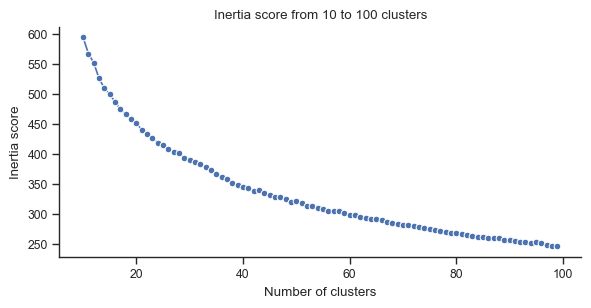

In [15]:
# Plot inertia scores vs. number of clusters
sns.set_theme(style='ticks')
sns.set_context("paper")
(
    sns.relplot(y=inertia_scores,
                x=range(min_k, max_k),
                kind='line',
                marker='o',
                height=3,
                aspect=2)
    .set(title=f"Inertia score from {min_k} to {max_k} clusters")
    .set_axis_labels("Number of clusters", "Inertia score")
);

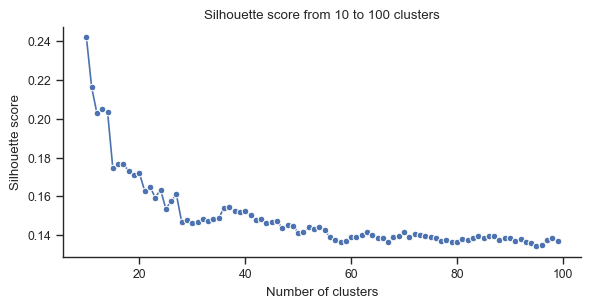

In [16]:
# Plot inertia scores vs. number of clusters
sns.set_theme(style='ticks')
sns.set_context("paper")
(
    sns.relplot(y=silhouette_scores,
                x=range(min_k, max_k),
                kind='line',
                marker='o',
                height=3,
                aspect=2)
    .set(title=f"Silhouette score from {min_k} to {max_k} clusters")
    .set_axis_labels("Number of clusters", "Silhouette score")
);

#### Conclusion - Number of Clusters

The lower the *intertia* score and the higher the *silhouette* score, the better our clusters fit our data. There is no perfect or optimal fit between the two, but we can look at these scores to identify the most favorable number of clusters, while keeping our business case in mind.

In my case, 20-100 playlists are desired, meaning 20-100 clusters. In this range, I see a slight local maximum of *silhouette* scores at around k=40. At the same time, *inertia* have already leveled off quite fine at k=40. I will thus choose my number of clusters, and hence number of playlists, to be **40**.

In [17]:
number_of_clusters = 40

<a id="kmeans_modelling"></a>
### 2.2.1&nbsp; K-Means Modelling

It's time for the actual clustering using the K-Means algorithm.

In [18]:
# Create a new dataframe for the final modelling
spotify_kmeans = spotify_minmax_scaled.copy()

# Initialise the model
# (Note that I want to use the same random state as in my analysis in section 2.2)
KMeans_model = KMeans(
    n_clusters=number_of_clusters, 
    n_init="auto", 
    random_state=42
)

# Fit the model to the transformed data
KMeans_model.fit(spotify_kmeans)

# Attach the cluster output to the DataFrame
spotify_kmeans.insert(loc=0, column="cluster_features", value=KMeans_model.labels_)

In [19]:
spotify_kmeans.sample(5)

,,cluster_features,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,loudness,tempo
name,artist,,,,,,,,,,
Tu Cuerpo Me Arrebata,Don Omar,36,0.819,0.645,0.0479,0.23200,0.000863,0.178,0.725,0.868850,0.443932
Antidote - Radio Edit,Swedish House Mafia,21,0.648,0.859,0.1110,0.00645,0.028200,0.135,0.633,0.897036,0.598299
I'm an Albatraoz,AronChupa,3,0.883,0.817,0.2350,0.60100,0.004490,0.110,0.595,0.889863,0.598523
Primrose,Eusebius,5,0.224,0.229,0.0405,0.98200,0.914000,0.113,0.206,0.693505,0.822160
No Good,Zonderling,3,0.840,0.855,0.2160,0.52300,0.015100,0.111,0.537,0.906051,0.589621


How many songs are there per cluster (/playlist)?

Min: 33 
Max: 251


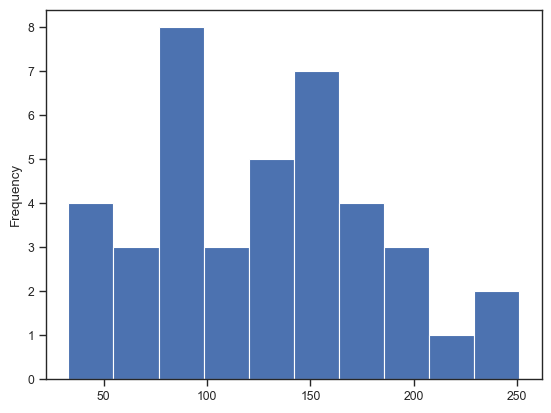

In [20]:
songs_per_playlist = spotify_kmeans["cluster_features"].value_counts()
print("Min:", songs_per_playlist.min(), "\nMax:", songs_per_playlist.max())
songs_per_playlist.plot.hist(bins=10);

Since our limit of between 50 and 250 songs is not a hard one, I would say we're good with a minimum of 33 and a maximum of 251 songs per playlist.

Let's group by clusters and look at the average score for the different attributes.

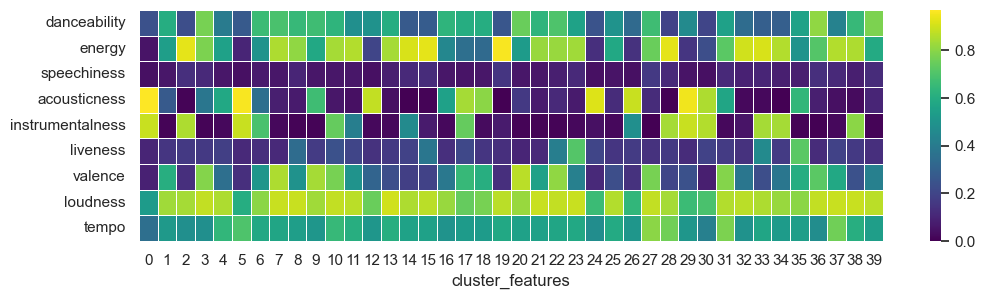

In [21]:
cluster_means = spotify_kmeans.groupby("cluster_features").mean().round(2)

sns.set(rc={'figure.figsize':(12,3)})
sns.heatmap(cluster_means.T, linewidths=0.7, cmap="viridis");

This plot tells us if the mean scores per song feature (danceability, energy, etc.) differ across clusters or not.

We can see that for some features, there are stark differences between clusters, such as acousticness or energy. These are hence good variables for clustering. Others, such as speechiness and tempo do almost not differ between clusters, rendering them less effective at finding differences between songs.

Good musical features for clustering our 5k songs are:
- acousticness
- instrumentalness
- energy
- valence
- danceability

Less good for clustering are the features:
- speechiness
- liveness
- loudness
- tempo

<a id="kmeans_plotting"></a>
### 2.2.2&nbsp; K-Means Plotting

#### 3D plot
Let's pick 3 of the musical features we preivously found to be most meaningful for clustering and visualize them in a 3D space. I'll plot them together with all of the clusters the K-Means algorithm gave me.

In [22]:
fig = px.scatter_3d(
    spotify_kmeans, x="acousticness", y="instrumentalness", z="energy",
    color="cluster_features",
    color_continuous_scale="blackbody",
    title='Clusters for 3 most important features',
    width=600, height=500
)
fig.update_traces(marker_size = 2)
fig.show()

<a id="pca"></a>
## 2.3&nbsp; Principal Component Analysis

A PCA is the optimal tool to **reduce dimensionality** and find the dimensions of a dataset that **explain most of its variation**. 

When we feed our scaled dataframe `spotify_minmax_scaled` with its musical attributes (varibales between 0 and 1) to a PCA, a new set of variables will be derived from the original attributes. These **principal components** are combinations of the original features taht capture the maximum amount of variance in the data.

The resulting dataframe with its principal components can be used to generate clusters for our songs using K-Means, just like we did above.

<a id="pca_modelling"></a>
### 2.3.1&nbsp; PCA Modelling

The `n_components` argument of the `PCA` module tells the model to fit as many principal components as are needed to explain XX % of the variance in the data. E.g. an `n_components=0.9` will keep as many components as are needed to explain 90 % of total variance.

In [23]:
# Initialise the PCA object
pca_model = PCA(n_components=0.9)

# Fit the PCA model to the data
pca_model.fit(spotify_minmax_scaled)

# Transform spotify_minmax_scaled based on the fit calculations
spotify_pca = pca_model.transform(spotify_minmax_scaled)

spotify_pca.head(5)

,,pca0,pca1,pca2,pca3,pca4
name,artist,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.258886,-0.495909,-0.267127,0.547687,0.557605
Saudade De Bahia,Antônio Carlos Jobim,-0.189820,-0.388910,0.092625,-0.171444,0.026410
"Canta Canta, Minha Gente",Martinho Da Vila,-0.303524,-0.478189,0.283602,-0.006334,0.031041
Mulher Eu Sei,Chico César,0.417139,-0.796497,-0.074345,0.113377,0.203925
Rosa Morena,Kurt Elling,0.471670,-0.733426,-0.160391,-0.070899,-0.007720


The pca0 component is the one that explains most of the variance in the data, followed by pca1, pca2 and so on. To find out how much variance exactly is explained by the different principal components, we can look at the `explained_variance_ratio_`.

Total variance explained by all principal components: 
 93.0


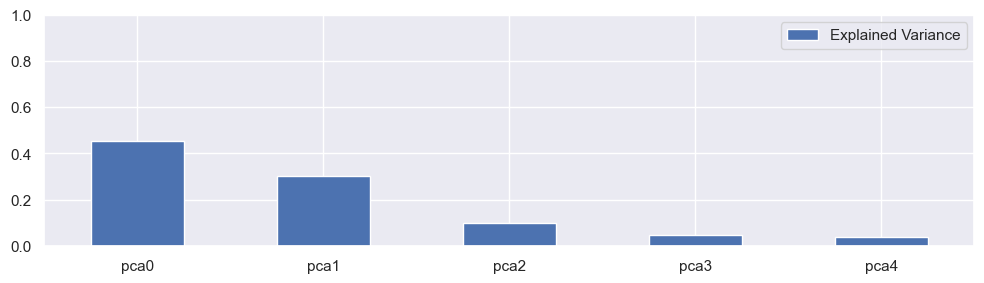

In [24]:
# Get the variance explained by each principal component
explained_variance_array = pca_model.explained_variance_ratio_

pca_total_var = pca_model.explained_variance_ratio_.sum() * 100
print("Total variance explained by all principal components: \n", pca_total_var.round())

# Plot the variance
explained_variance_df = pd.DataFrame(
    explained_variance_array, 
    index=spotify_pca.columns, 
    columns=["Explained Variance"]
)
explained_variance_df.plot.bar(rot=0, ylim=(0, 1));

#### Optimal number of clusters (PCA)

In [25]:
# Random state
seed = 42
# Range of clusters
min_k = 10
max_k = 100

inertia_scores = []
silhouette_scores = []

for i in range(min_k, max_k):

    # Create a KMeans object with the specified number of clusters
    KMeans_clusters_pca = KMeans(n_clusters=i, n_init="auto", random_state = seed)

    # Fit the KMeans model to the scaled data
    KMeans_clusters_pca.fit(spotify_pca)

    # Append inertia score
    inertia_scores.append(KMeans_clusters_pca.inertia_)

    # Calculate the silhouette score
    labels = KMeans_clusters_pca.labels_
    sil_score = silhouette_score(spotify_pca, labels)
    # Append silhouette score
    silhouette_scores.append(sil_score)

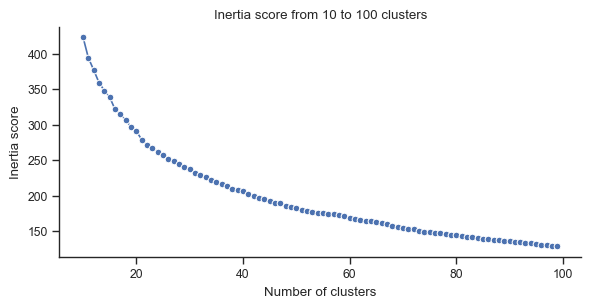

In [26]:
# Plot inertia scores vs. number of clusters
sns.set_theme(style='ticks')
sns.set_context("paper")
(
    sns.relplot(y=inertia_scores,
                x=range(min_k, max_k),
                kind='line',
                marker='o',
                height=3,
                aspect=2)
    .set(title=f"Inertia score from {min_k} to {max_k} clusters")
    .set_axis_labels("Number of clusters", "Inertia score")
);

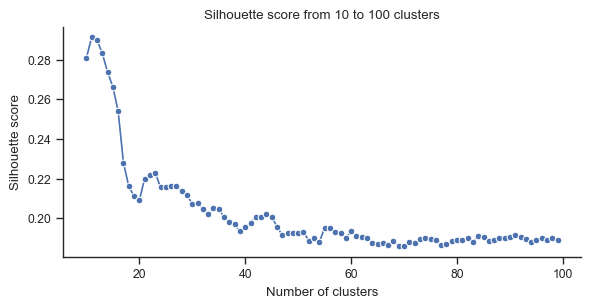

In [27]:
# Plot inertia scores vs. number of clusters
sns.set_theme(style='ticks')
sns.set_context("paper")
(
    sns.relplot(y=silhouette_scores,
                x=range(min_k, max_k),
                kind='line',
                marker='o',
                height=3,
                aspect=2)
    .set(title=f"Silhouette score from {min_k} to {max_k} clusters")
    .set_axis_labels("Number of clusters", "Silhouette score")
);

Also for the PCA transformed dataset, 40 clusters seem to be a good number that combines decreased *inertia* and an increased *silhouette* score.

In [28]:
number_of_clusters_pca = 40

#### PCA Clustering

Finally, let's cluster the resulting `spotify_pca` dataframe.

In [29]:
# Create new model for the spotify_pca dataframe
KMeans_pca_model = KMeans(
    n_clusters=number_of_clusters_pca, 
    n_init="auto", 
    random_state = 42
)

# Fit the model to the transformed data
KMeans_pca_model.fit(spotify_pca)

# Attach the cluster output to the DataFrame
spotify_pca.insert(loc=0, column="cluster_pca", value=KMeans_pca_model.labels_)

In [30]:
spotify_pca.sample(5)

,,cluster_pca,pca0,pca1,pca2,pca3,pca4
name,artist,,,,,,
Piano Man,Billy Joel,10,0.110597,-0.281642,-0.222742,0.201236,-0.292285
Silence - Tiësto's Big Room Remix,Marshmello,39,-0.381687,0.274117,-0.428494,0.536605,0.481995
Un Poco Loca (feat. De La Ghetto),Jowell & Randy,23,-0.432284,-0.292543,0.211099,0.021342,-0.120698
SLVR,Steve Angello,33,0.289778,0.605328,0.255767,-0.315013,0.206568
Rosa Morena - Live At Carnegie Hall/1964,Stan Getz,27,0.520197,-0.622964,-0.100210,0.450928,0.232017


#### Which features contributed most to the PCs?

In [31]:
# Get the component weights
pca_weights = pd.DataFrame(
    pca_model.components_, 
    columns=spotify_minmax_scaled.columns, 
    index=['pca0','pca1', 'pca2', 'pca3', 'pca4']
)
pca_weights

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,loudness,tempo
pca0,-0.233279,-0.447982,-0.034351,0.573163,0.528173,-0.039380,-0.318286,-0.174071,-0.055430
pca1,-0.319710,0.413919,0.033613,-0.512830,0.569086,0.032833,-0.366190,0.045852,0.034595
pca2,0.317041,0.042987,-0.016200,-0.004560,0.610584,-0.049949,0.722012,-0.011446,0.024777
pca3,-0.352066,0.278636,0.016671,0.317238,-0.035965,0.778117,0.218444,0.047112,0.201982
pca4,0.518651,-0.169032,0.030339,-0.165579,0.103215,0.572733,-0.247871,-0.007739,-0.523371


In [32]:
# Set the number of top features to identify
top_n = 4

# Identify the top N important features for each principal component
top_features_df = pca_weights.apply(lambda row: row.abs().nlargest(top_n).index.tolist(), axis=1)

# Display the DataFrame
print(top_features_df)

pca0    [acousticness, instrumentalness, energy, valence]
pca1    [instrumentalness, acousticness, energy, valence]
pca2    [valence, instrumentalness, danceability, live...
pca3       [liveness, danceability, acousticness, energy]
pca4             [liveness, tempo, danceability, valence]
dtype: object


The PCA analysis shows that the most important musical features in order of relative importance are:
1. `instrumentalness`
2. `acousticness`
3. `energy`
4. `valence`
5. `danceability`

The other features play only minor roles in explaining variability. 

<a id="pca_plotting"></a>
### 2.3.1&nbsp; PCA Plotting

I've now clustered our data in two different ways:
- Feeding K-Means the original musical features (partly minmax-scaled) and 
- feeding it principal components from the PCA. 

Time to find out which approach created better clusters. Therefore, I'll visualize both clustering results on 3D and 2D PCA plots.

In [33]:
# First, I'll fetch the original feature clusters from the KMeans_model
spotify_pca.insert(loc=1, column="cluster_features", value=KMeans_model.labels_)

#### 3D plot
Let's pick the first 3 principal components (PCs) and visualize them in a 3D space. 

I'll create one plot for the **PCA clusters**, one for the **feature clusters**.

In [34]:
# Calculate the first three PCs' total variance
explained_var_3dims = pca_model.explained_variance_ratio_[0:3].sum() * 100

# Plot PCA clusters
fig = px.scatter_3d(
    spotify_pca, x="pca0", y="pca1", z="pca2",
    color="cluster_pca",
    color_continuous_scale="turbo",
    title=f'|3 PCs|PCA Clusters| Total Explained Variance: {explained_var_3dims:.2f}%',
    labels={'pca0': 'PC 1', 'pca1': 'PC 2', 'pca2': 'PC 3'},
    width=600, height=500
)
fig.update_traces(marker_size = 1.7)
fig.show()

In [35]:
# Plot the feature clusters
fig = px.scatter_3d(
    spotify_pca, x="pca0", y="pca1", z="pca2",
    color="cluster_features",
    color_continuous_scale="blackbody",
    title=f'|3 PCs|Feature Clusters| Total Explained Variance: {explained_var_3dims:.2f}%',
    labels={'pca0': 'PC 1', 'pca1': 'PC 2', 'pca2': 'PC 3'},
    width=600, height=500
)
fig.update_traces(marker_size = 1.7)
fig.show()

#### 2D plot including Loadings
*Loadings* are the coefficients that represent the contribution of each original variable to the corresponding principal component (PC). They are essentially the weights that determine how much each variable contributes to the formation of each PC.

In [36]:
features = list(spotify_minmax_scaled.columns)
loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)

explained_var_2dims = pca_model.explained_variance_ratio_[0:2].sum() * 100

fig = px.scatter(
    spotify_pca, 
    x="pca0", y="pca1",
    labels={'pca0': 'PC 1', 'pca1': 'PC 2'},
    title=f'|2 PCs|PCA Clusters| Total Explained Variance: {explained_var_2dims:.2f}%',
    color="cluster_pca",
    color_continuous_scale="turbo",
    width=600, height=500
)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.update_traces(marker_size=3)
fig.show()

In [37]:
fig = px.scatter(
    spotify_pca, 
    x="pca0", y="pca1",
    labels={'pca0': 'PC 1', 'pca1': 'PC 2'},
    title=f'|2 PCs|Feature Clusters| Total Explained Variance: {explained_var_2dims:.2f}%',
    color="cluster_features",
    color_continuous_scale="blackbody",
    width=600, height=500
)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.update_traces(marker_size=3)
fig.show()

Judging based on the 3D and 2D plots, it seems the **clusters defined by the PCA** result in much more distinct and cleaner clusters than the ones provided by the K-Means algorithm *without* principal components. 

#### Take-home messages:
Firstly, the most important musical features in order of relative importance are:
1. `instrumentalness`
2. `acousticness`
3. `energy`
4. `valence`
5. `danceability`

Secondly, the **clusters defined by the PCA** result in much more distinct and cleaner clusters than the ones provided by the K-Means algorithm without principal components. 

___
<a id="interpretation"></a>
# 3&nbsp; Interpretation

We already know the most important musical features of our dataset. We also know that our clustering of principal components results in nice and distinct clusters. Hence, making playlists based on these clusters should work nicely.

In a final step, we need to find out if the playlists actually make sense to a human. Therefore, we'll need to probe the playlists and find out if the clusters make sense to us.

Questions to answer are:
- Which kinds of songs are clustered together?
- Do the playlists contain songs of similar musical genres?
- Do the clusters feel sufficiently different from each other and the songs inside one playlist sufficiently similar?

<a id="probing"></a>
## 3.1&nbsp; Probe playlists

To probe the different playlists and get an impression of which songs get grouped together, I'll first need the songs' HTMLs from the `spotify_htmls` dataframe.

In [38]:
# Use PCA clusters for a final probing dataframe
spotify_probing = spotify_pca.copy()
htmls = spotify_htmls.set_index(["name", "artist"])["html"]
spotify_probing.insert(loc=1, column="html", value=htmls)
spotify_probing = spotify_probing[["cluster_pca", "html"]]

In [39]:
# For displaying the whole html in the output
pd.set_option('display.max_colwidth', 100)

# Get sample of cluster
def get_cluster_sample(df: pd.DataFrame, cluster: int):
    sample = df[df["cluster_pca"] == cluster].sample(8)
    return sample

In [52]:
# Take samples
get_cluster_sample(df=spotify_probing, cluster=22)

,,cluster_pca,html
name,artist,,
Waterfalls,Alexis Ffrench,22,https://open.spotify.com/track/2mRzR5As98D4UWLIH3v5Rl
You Say,The Piano Guys,22,https://open.spotify.com/track/4rvtJbA7f9LH69rECWAO54
Yesterday,David Schultz,22,https://open.spotify.com/track/2PSARXIFrABbd5wil6ogJ9
"The Well-Tempered Clavier, Book I: Prelude No. 23 in B Major, BWV 868",Johann Sebastian Bach,22,https://open.spotify.com/track/1rpASMR3qW8rok9r0Wl590
"Symphony in D, H.I No.6 - ""Le Matin"": 1. Adagio - Allegro",Franz Joseph Haydn,22,https://open.spotify.com/track/1ZZO2cU9xSbJrtBclJA3wU
I Giorni,Lavinia Meijer,22,https://open.spotify.com/track/3kEzQNwz0SWn53UPX7rwS6
Until Next Time,Henry Smith,22,https://open.spotify.com/track/2poQJtHut7ZGP6O9UA8jGk
Adrift Together,Subsona,22,https://open.spotify.com/track/1O2xcKAglBjpWGE6ekfRsm


Now everything is prepared for the manual probing of our playlists. I can simply use the links to open the songs in Spotify and see whether the compositions inside each playlist make sense.

<a id="conclusion"></a>
## 3.2&nbsp; Conclusion

- In this notebook I loaded a **5k songs** dataframe of songs and their musical features.
- I **transformed** the data and used **K-Means Clustering** to assign the songs to individual playlists.
- The clustering worked best, when the features were transformed to principal components using a **PCA**. 
- The resulting playlists were of moderate size (between 33-251 songs each) and clustered nicely in a 3D space, with relatively clear distinctions between different playlists.

#### Musical inspection:

When probing the playlists manually and listening to some of their songs, I found that the algorithm did an alright job in grouping songs that seemed similar to me. Mostly, the songs inside a playlist had a similar vibe. Nonetheless, I was often surprised to find very different types of genres ending up in the same list, e.g. Shakira (Whenever, Wherever) and Eminem (Without Me). At times, that worked very well, as the songs were still somewhat similar (e.g. the tempo of the songs). Sometimes, though, it didn't work at all. For example when encountering Céline Dion (The Power of Love) and God Forsaken (Until Death Joins Us Again) in the same playlist. You really don't want these two together.

If I were to continue this project, I would certainly try out **Hierarchical Clustering**. This might lead to playlists that are better organized in terms of genres and sub-genres. [This video](https://www.youtube.com/watch?v=7xHsRkOdVwo) shows what hierarchical clustering methods are all about.

Summing up, there's certainly room for improvement, but this approach is a **good starting point** for **automating playlist creation** for large datasets of songs and their musical features.